In [1]:
import pandas as pd

#Read in merged data
df = pd.read_csv("/content/drive/MyDrive/project/mergedData.csv")

#Inspected column names to determine which should be used as input / target variables
df.columns

Index(['OBJECTID', 'Planning Authority', 'full_address', 'Decision',
       'Decision Binary', 'site_shape_area', 'ED_ENGLISH',
       'Total Population (Normalisation)', 'Total dwellings (Normalisation)',
       'PopulationDensity', 'smallarea_shape_area', 'PersonalVehicle',
       'WalkCycle', 'PublicTransport', 'UnderHalfHourJourney',
       'UnderHourJourney', 'OverHourJourney', 'NoLC', 'CollegeEducation',
       'EmploymentRate', 'NoCentralHeating', 'ServedByPublicSystem_Water',
       'ServedByPublicSystem_Sewerage', 'HasRenewableEnergy'],
      dtype='object')

In [2]:
#Inspected rows containing any null values
df[df.isnull().any(axis=1)]


,OBJECTID,Planning Authority,full_address,Decision,Decision Binary,site_shape_area,ED_ENGLISH,Total Population (Normalisation),Total dwellings (Normalisation),PopulationDensity,...,UnderHalfHourJourney,UnderHourJourney,OverHourJourney,NoLC,CollegeEducation,EmploymentRate,NoCentralHeating,ServedByPublicSystem_Water,ServedByPublicSystem_Sewerage,HasRenewableEnergy
66490,491262.0,Dublin City Council,"59 Collins Avenue, Donnycarney, Dublin 9, D09 ...",GRANT PERMISSION,1,1196.033203,WHITEHALL A,243.0,0.0,0.001008,...,0.8125,0.140625,0.046875,0.0,0.909091,0.049383,NaN,NaN,NaN,NaN


In [3]:
#One instance with no infrastructure data available so just removed from data
df = df.dropna()

In [4]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

# Baseline Models: Logistic Regression, Random Forest, Gradient Boosting, Neural Network
# No balancing techniques or hyperparameter tuning
# Default settings

# Declared input features
selected_cols = [
    'PopulationDensity', 'PersonalVehicle',
    'WalkCycle', 'PublicTransport', 'UnderHalfHourJourney',
    'UnderHourJourney', 'OverHourJourney', 'NoLC', 'CollegeEducation',
    'EmploymentRate', 'NoCentralHeating', 'ServedByPublicSystem_Water',
    'ServedByPublicSystem_Sewerage', 'HasRenewableEnergy'
]

# Kept only these columns
df = df[selected_cols + ['Decision Binary']]

# Converted to array of ints
X = df[selected_cols].values.astype(float)

#Declared target feature
y = df['Decision Binary'].values.astype(int)


# Standardized input features to normalised scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into train and test sets (80/20)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Initialised dictionary to store results
results = {}

# Created function to calculate metrics for each model
def add_class_metrics(y_true, y_pred, y_proba, model_name):
    report = classification_report(y_true, y_pred, output_dict=True)
    results[model_name] = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'AUC': roc_auc_score(y_true, y_proba),
        'Precision_0': report['0']['precision'],
        'Recall_0': report['0']['recall'],
        'F1_0': report['0']['f1-score'],
        'Precision_1': report['1']['precision'],
        'Recall_1': report['1']['recall'],
        'F1_1': report['1']['f1-score']
    }

# Logistic Regression
log_reg = LogisticRegression(max_iter=1000)  # Initialised model
log_reg.fit(X_train, y_train)                # Trained model
y_pred_lr = log_reg.predict(X_test)          # Predicted class labels
y_proba_lr = log_reg.predict_proba(X_test)[:,1]  # Predicted probabilities for positive class
add_class_metrics(y_test, y_pred_lr, y_proba_lr, 'Logistic Regression')  # Stored metrics

# Random Forest
rf = RandomForestClassifier(random_state=42, n_estimators=100)  # Initialised model
rf.fit(X_train, y_train)                                        # Trained model
y_pred_rf = rf.predict(X_test)                                   # Predicted class labels
y_proba_rf = rf.predict_proba(X_test)[:,1]                       # Predicted probabilities for positive class
add_class_metrics(y_test, y_pred_rf, y_proba_rf, 'Random Forest')  # Stored metrics


# XGBoost
xgb = XGBClassifier(objective='binary:logistic', eval_metric='logloss')  # Initialised model
xgb.fit(X_train, y_train)                                                # Trained model
y_pred_xgb = xgb.predict(X_test)                                         # Predicted class labels
y_proba_xgb = xgb.predict_proba(X_test)[:,1]                              # Predicted probabilities for positive class
add_class_metrics(y_test, y_pred_xgb, y_proba_xgb, 'XGBoost')           # Stored metrics


# PyTorch Neural Network
# Convert data to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.reshape(-1,1), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# Defined simple feedforward network
class Net(nn.Module):
    def __init__(self, input_dim):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)  # First hidden layer
        self.relu1 = nn.ReLU()               # Activation
        self.fc2 = nn.Linear(32,16)          # Second hidden layer
        self.relu2 = nn.ReLU()               # Activation
        self.fc3 = nn.Linear(16,1)           # Output layer
        self.sigmoid = nn.Sigmoid()          # Sigmoid for binary output
    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

# Initialised model, loss, optimizer
model = Net(X_train.shape[1])
criterion = nn.BCELoss()
optimiser = optim.Adam(model.parameters(), lr=0.001)

# Trained network for 50 epochs
for epoch in range(50):
    optimiser.zero_grad()                 # Resetted gradients
    outputs = model(X_train_tensor)       # Forward pass
    loss = criterion(outputs, y_train_tensor)  # Computed loss
    loss.backward()                       # Backpropagation
    optimiser.step()                      # Updated weights

# Made predictions
with torch.no_grad():
    y_pred_prob_nn = model(X_test_tensor).numpy().flatten()  # Probabilities
    y_pred_nn = (y_pred_prob_nn > 0.5).astype(int)           # Converted to class labels

# Stored metrics
add_class_metrics(y_test, y_pred_nn, y_pred_prob_nn, 'Neural Network')


# Summary Table
summary_table = pd.DataFrame(results).T  # Converted results dict to DataFrame
summary_table

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

,Accuracy,AUC,Precision_0,Recall_0,F1_0,Precision_1,Recall_1,F1_1
Logistic Regression,0.870922,0.581903,0.000000,0.000000,0.000000,0.870922,1.000000,0.931008
Random Forest,0.862672,0.665860,0.373272,0.094131,0.150348,0.879138,0.976576,0.925299
XGBoost,0.869422,0.677250,0.453704,0.056944,0.101187,0.876267,0.989838,0.929597
Neural Network,0.870922,0.482079,0.000000,0.000000,0.000000,0.870922,1.000000,0.931008


In [5]:
import numpy as np

#Large over sampling of positive class in dataa
#Retrained models taking class imbalance into account
# Approach 1: Balancing class weights

# Reset results dictionary
results = {}

# Logistic Regression (class_weight)
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced')  # Initialised with balanced class weights
log_reg.fit(X_train, y_train)                                           # Trained model
y_pred_lr = log_reg.predict(X_test)                                 # Predicted labels
y_proba_lr = log_reg.predict_proba(X_test)[:,1]                     # Predicted probabilities
add_class_metrics(y_test, y_pred_lr, y_proba_lr, 'Logistic Regression (Weighted)')  # Stored metrics


# Random Forest (class_weight)
rf = RandomForestClassifier(random_state=42, n_estimators=100, class_weight='balanced')  # Initialised with balanced class weights
rf.fit(X_train, y_train)                                                                # Trained model
y_pred_rf = rf.predict(X_test)                                                      # Predicted labels
y_proba_rf = rf.predict_proba(X_test)[:,1]                                          # Predicted probabilities
add_class_metrics(y_test, y_pred_rf, y_proba_rf, 'Random Forest (Weighted)')       # Stored metrics

# Calculated class weights for NN and XGBoost
neg, pos = np.bincount(y_train)                 # Counted number of negative and positive samples
pos_weight = torch.tensor([neg/pos], dtype=torch.float32)  # Weighted for minority class

# XGBoost (scale_pos_weight)
xgb = XGBClassifier(objective='binary:logistic', eval_metric='logloss', scale_pos_weight=neg/pos)  # Initialised model with scale_pos_weight
xgb.fit(X_train, y_train)                                                                         # Trained
y_pred_xgb = xgb.predict(X_test)                                                             # Predicted labels
y_proba_xgb = xgb.predict_proba(X_test)[:,1]                                                 # Predicted probabilities
add_class_metrics(y_test, y_pred_xgb, y_proba_xgb, 'XGBoost (Weighted)')                    # Stored metrics


# Neural Network (BCEWithLogitsLoss pos_weight)
model = Net(X_train.shape[1])                         # Initialised network
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)  # Weighted loss for minority class
optimiser = optim.Adam(model.parameters(), lr=0.001) # Adam optimiser

# Trained network
for epoch in range(50):
    optimiser.zero_grad()                       # Resetted gradients
    outputs = model(X_train_tensor)            # Forward pass
    loss = criterion(outputs, y_train_tensor)  # Computed weighted loss
    loss.backward()                                # Backpropagation
    optimiser.step()                            # Updated weights

# Made predictions
with torch.no_grad():
    y_pred_prob_nn = torch.sigmoid(model(X_test_tensor)).numpy().flatten()  # Probabilities
    y_pred_nn = (y_pred_prob_nn > 0.5).astype(int)                            # Class labels

# Stored NN metrics
add_class_metrics(y_test, y_pred_nn, y_pred_prob_nn, 'Neural Network (Weighted)')


# Summary Table
summary_table = pd.DataFrame(results).T
summary_table


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,Accuracy,AUC,Precision_0,Recall_0,F1_0,Precision_1,Recall_1,F1_1
Logistic Regression (Weighted),0.571364,0.581807,0.161869,0.555491,0.250688,0.896997,0.573717,0.699827
Random Forest (Weighted),0.708018,0.669046,0.222108,0.504358,0.308403,0.909496,0.738202,0.814945
XGBoost (Weighted),0.663392,0.671973,0.207938,0.572342,0.305048,0.914379,0.676886,0.777910
Neural Network (Weighted),0.870922,0.555369,0.000000,0.000000,0.000000,0.870922,1.000000,0.931008


In [6]:
from imblearn.under_sampling import RandomUnderSampler
import numpy as np

# Approach 2: Random Undersampling of Majority Positive Class

# Reset results
results = {}

# Applied random under-sampling to training data (Reduced majority class to same size as minority)
rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

# Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_rus, y_train_rus)
y_pred_lr = log_reg.predict(X_test)
y_proba_lr = log_reg.predict_proba(X_test)[:,1]
add_class_metrics(y_test, y_pred_lr, y_proba_lr, 'Logistic Regression (Undersampling)')

# Random Forest
rf = RandomForestClassifier(random_state=42, n_estimators=100)
rf.fit(X_train_rus, y_train_rus)
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:,1]
add_class_metrics(y_test, y_pred_rf, y_proba_rf, 'Random Forest (Undersampling)')

# XGBoost
xgb = XGBClassifier(objective='binary:logistic', eval_metric='logloss')
xgb.fit(X_train_rus, y_train_rus)
y_pred_xgb = xgb.predict(X_test)
y_proba_xgb = xgb.predict_proba(X_test)[:,1]
add_class_metrics(y_test, y_pred_xgb, y_proba_xgb, 'XGBoost (Undersampling)')

# Neural Network
# Convert resampled data to tensors
X_train_tensor = torch.tensor(X_train_rus, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_rus.reshape(-1,1), dtype=torch.float32)

model = Net(X_train_rus.shape[1])
criterion = nn.BCELoss()
optimiser = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(50):
    optimiser.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimiser.step()

with torch.no_grad():
    y_pred_prob_nn = model(X_test_tensor).numpy().flatten()
    y_pred_nn = (y_pred_prob_nn > 0.5).astype(int)

add_class_metrics(y_test, y_pred_nn, y_pred_prob_nn, 'Neural Network (Undersampling)')

# Summary table
summary_table_rus = pd.DataFrame(results).T
summary_table_rus


,Accuracy,AUC,Precision_0,Recall_0,F1_0,Precision_1,Recall_1,F1_1
Logistic Regression (Undersampling),0.573764,0.581888,0.161368,0.548518,0.249373,0.896165,0.577506,0.702383
Random Forest (Undersampling),0.618165,0.645562,0.189801,0.599070,0.288271,0.912669,0.620996,0.739097
XGBoost (Undersampling),0.604065,0.648749,0.185356,0.608948,0.284203,0.912358,0.603341,0.726349
Neural Network (Undersampling),0.558689,0.591327,0.164112,0.590936,0.256883,0.901345,0.553910,0.686153


In [7]:
from imblearn.over_sampling import RandomOverSampler
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import pandas as pd

# Reset results
results = {}

# Random oversampling of minority class
ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros = ros.fit_resample(X_train.copy(), y_train.copy())

# -------------------------------
# Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_ros, y_train_ros)
y_pred_lr = log_reg.predict(X_test)
y_proba_lr = log_reg.predict_proba(X_test)[:,1]
add_class_metrics(y_test, y_pred_lr, y_proba_lr, 'Logistic Regression (Oversampling)')

# -------------------------------
# Random Forest
rf = RandomForestClassifier(random_state=42, n_estimators=100)
rf.fit(X_train_ros, y_train_ros)
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:,1]
add_class_metrics(y_test, y_pred_rf, y_proba_rf, 'Random Forest (Oversampling)')

# -------------------------------
# XGBoost
xgb = XGBClassifier(objective='binary:logistic', eval_metric='logloss', tree_method='hist')
xgb.fit(X_train_ros, y_train_ros)
y_pred_xgb = xgb.predict(X_test)
y_proba_xgb = xgb.predict_proba(X_test)[:,1]
add_class_metrics(y_test, y_pred_xgb, y_proba_xgb, 'XGBoost (Oversampling)')

# -------------------------------
# Neural Network
X_train_tensor = torch.tensor(X_train_ros, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_ros.reshape(-1,1), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

class Net(nn.Module):
    def __init__(self, n_features):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_features, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 1)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

model = Net(X_train_ros.shape[1])
criterion = nn.BCELoss()
optimiser = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(50):
    optimiser.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimiser.step()

with torch.no_grad():
    y_pred_prob_nn = model(X_test_tensor).numpy().flatten()
    y_pred_nn = (y_pred_prob_nn > 0.5).astype(int)

add_class_metrics(y_test, y_pred_nn, y_pred_prob_nn, 'Neural Network (Oversampling)')

# -------------------------------
# Summary table
summary_table_ros = pd.DataFrame(results).T
summary_table_ros


,Accuracy,AUC,Precision_0,Recall_0,F1_0,Precision_1,Recall_1,F1_1
Logistic Regression (Oversampling),0.568889,0.581648,0.160627,0.553748,0.249020,0.896216,0.571133,0.697665
Random Forest (Oversampling),0.652216,0.664285,0.203779,0.582801,0.301972,0.914636,0.662504,0.768416
XGBoost (Oversampling),0.669467,0.672111,0.209055,0.560721,0.304561,0.913273,0.685584,0.783216
Neural Network (Oversampling),0.604140,0.591583,0.170465,0.534573,0.258500,0.899068,0.614451,0.729998


In [8]:
from imblearn.over_sampling import SMOTE
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import pandas as pd

# Reset results
results = {}

# Applied SMOTE to training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train.copy(), y_train.copy())

#Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_smote, y_train_smote)
y_pred_lr = log_reg.predict(X_test)
y_proba_lr = log_reg.predict_proba(X_test)[:,1]
add_class_metrics(y_test, y_pred_lr, y_proba_lr, 'Logistic Regression (SMOTE)')

#Random Forest
rf = RandomForestClassifier(random_state=42, n_estimators=100)
rf.fit(X_train_smote, y_train_smote)
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:,1]
add_class_metrics(y_test, y_pred_rf, y_proba_rf, 'Random Forest (SMOTE)')

#XGBoost
xgb = XGBClassifier(objective='binary:logistic', eval_metric='logloss', tree_method='hist')
xgb.fit(X_train_smote, y_train_smote)
y_pred_xgb = xgb.predict(X_test)
y_proba_xgb = xgb.predict_proba(X_test)[:,1]
add_class_metrics(y_test, y_pred_xgb, y_proba_xgb, 'XGBoost (SMOTE)')

#Neural Network
X_train_tensor = torch.tensor(X_train_smote, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_smote.reshape(-1,1), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

model = Net(X_train_smote.shape[1])
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(50):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

with torch.no_grad():
    y_pred_prob_nn = model(X_test_tensor).numpy().flatten()
    y_pred_nn = (y_pred_prob_nn > 0.5).astype(int)

add_class_metrics(y_test, y_pred_nn, y_pred_prob_nn, 'Neural Network (SMOTE)')

#Summary table
summary_table_smote = pd.DataFrame(results).T
summary_table_smote


,Accuracy,AUC,Precision_0,Recall_0,F1_0,Precision_1,Recall_1,F1_1
Logistic Regression (SMOTE),0.567839,0.582150,0.162067,0.563045,0.251688,0.897743,0.568550,0.696193
Random Forest (SMOTE),0.759919,0.662566,0.243056,0.406740,0.304282,0.902325,0.812263,0.854929
XGBoost (SMOTE),0.721368,0.673104,0.228486,0.487507,0.311144,0.908705,0.756028,0.825365
Neural Network (SMOTE),0.613815,0.593976,0.173648,0.529924,0.261580,0.899889,0.626249,0.738537


In [9]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
import pandas as pd

#Applying hyperparameter tuning to the model using GridSearchCv

#Reset results
results = {}

#Initialised base gradient boosting model to be tuned with class balancing applied
xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    scale_pos_weight=neg/pos
)

#Combinations of parameters to be tested
param_grid = {
    'learning_rate': [0.05, 0.10, 0.20],
    'max_depth': [4, 5, 6],
    'min_child_weight': [1, 3, 5],
    'gamma': [0.0, 0.1, 0.2],
    'colsample_bytree': [0.6]
}

#Initialised GridSearch algorithm settings
grid = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='roc_auc',
    n_jobs=-1,
    cv=3,
    verbose=3
)

#Fitted training data to GridSearch model
grid.fit(X_train, y_train)

#Made predictions using tuned model
y_pred_xgb = grid.predict(X_test)
y_proba_xgb = grid.predict_proba(X_test)[:,1]

#Calculated evaluation metrics for tuned model
add_class_metrics(y_test, y_pred_xgb, y_proba_xgb, 'XGBoost (Tuned)')

#Printed optimal parameters
print("Best Parameters Found:", grid.best_params_)

#Summary table
summary_table_gridsearch = pd.DataFrame(results).T
summary_table_gridsearch



Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best Parameters Found: {'colsample_bytree': 0.6, 'gamma': 0.2, 'learning_rate': 0.2, 'max_depth': 6, 'min_child_weight': 1}


,Accuracy,AUC,Precision_0,Recall_0,F1_0,Precision_1,Recall_1,F1_1
XGBoost (Tuned),0.669542,0.675087,0.20973,0.563626,0.305704,0.913757,0.685239,0.783169


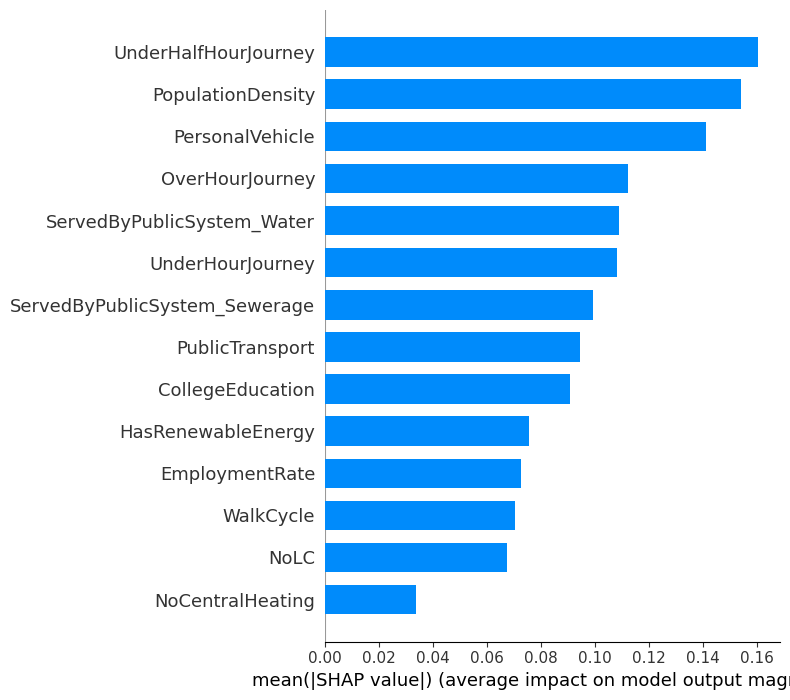

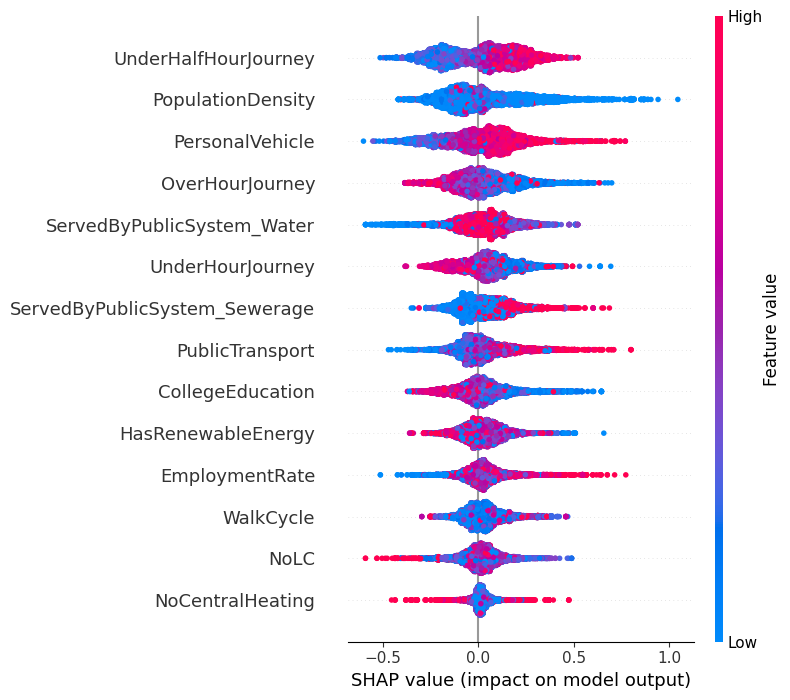

In [10]:
import shap

#Calculating SHAP feature importance values of tuned model

#Converted training data from array to df
X_train_df = pd.DataFrame(X_train, columns=selected_cols)
X_test_df = pd.DataFrame(X_test, columns=selected_cols)

# Using tuned model
xgb_best = grid.best_estimator_

# Created SHAP TreeExplainer
explainer = shap.TreeExplainer(xgb_best)

# Computed SHAP values for the test set
shap_values = explainer.shap_values(X_test_df)

# Feature importance summary (bar plot)
shap.summary_plot(shap_values, X_test_df, plot_type="bar")

# Detailed SHAP summary (dot plot)
shap.summary_plot(shap_values, X_test_df)


In [11]:
#Outputting numerical values of SHAP importance values

# Convert SHAP values (numpy array) to DataFrame
shap_df = pd.DataFrame(shap_values, columns=selected_cols)

# Selecting mean absolute values for each feature
shap_importance = shap_df.abs().mean().sort_values(ascending=False)

#Inspecting results
shap_importance


,0
UnderHalfHourJourney,0.160446
PopulationDensity,0.153866
PersonalVehicle,0.141069
OverHourJourney,0.112201
ServedByPublicSystem_Water,0.108842
UnderHourJourney,0.108316
ServedByPublicSystem_Sewerage,0.099328
PublicTransport,0.094305
CollegeEducation,0.090763
HasRenewableEnergy,0.075417


,Mean Abs SHAP
Socioeconomic Conditions,0.096137
Access to Infrastructure,0.079371
Access to Public Services,0.114438


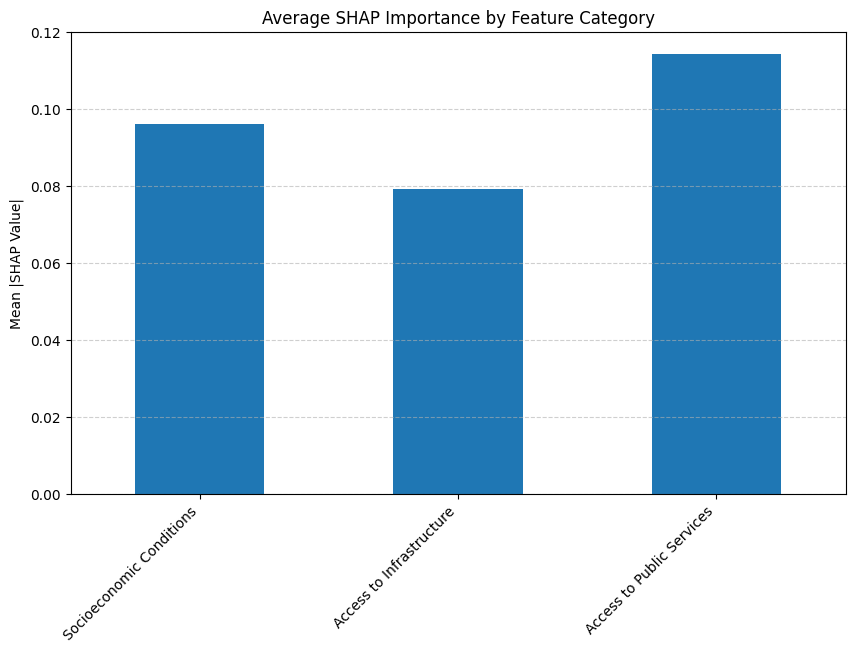

In [12]:
import matplotlib.pyplot as plt

#Calculated average mean SHAP importance values for the three main categories

#Split up feature variables

socioeconomic = [
    'PopulationDensity',
    'NoLC',
    'CollegeEducation',
    'EmploymentRate'
]

infrastructure = [
    'ServedByPublicSystem_Water',
    'ServedByPublicSystem_Sewerage',
    'NoCentralHeating',
    'HasRenewableEnergy'
]

public_services = [
    'PublicTransport',
    'WalkCycle',
    'PersonalVehicle',
    'UnderHalfHourJourney',
    'UnderHourJourney',
    'OverHourJourney'
]

#Converted shap values to a dataframe
shap_df = pd.DataFrame(shap_values, columns=selected_cols)

# Computed absolute SHAP values
abs_shap = shap_df.abs()

# Computed mean per category

category_importance = {
    "Socioeconomic Conditions": abs_shap[socioeconomic].mean().mean(),
    "Access to Infrastructure": abs_shap[infrastructure].mean().mean(),
    "Access to Public Services": abs_shap[public_services].mean().mean()
}

category_importance_df = pd.DataFrame.from_dict(
    category_importance, orient='index', columns=['Mean Abs SHAP']
)

#Outputted mean per category
display(category_importance_df)

#Created bar chart for comparison between categories
plt.figure(figsize=(10, 6))
category_importance_df['Mean Abs SHAP'].plot(kind='bar')
plt.title("Average SHAP Importance by Feature Category")
plt.ylabel("Mean |SHAP Value|")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


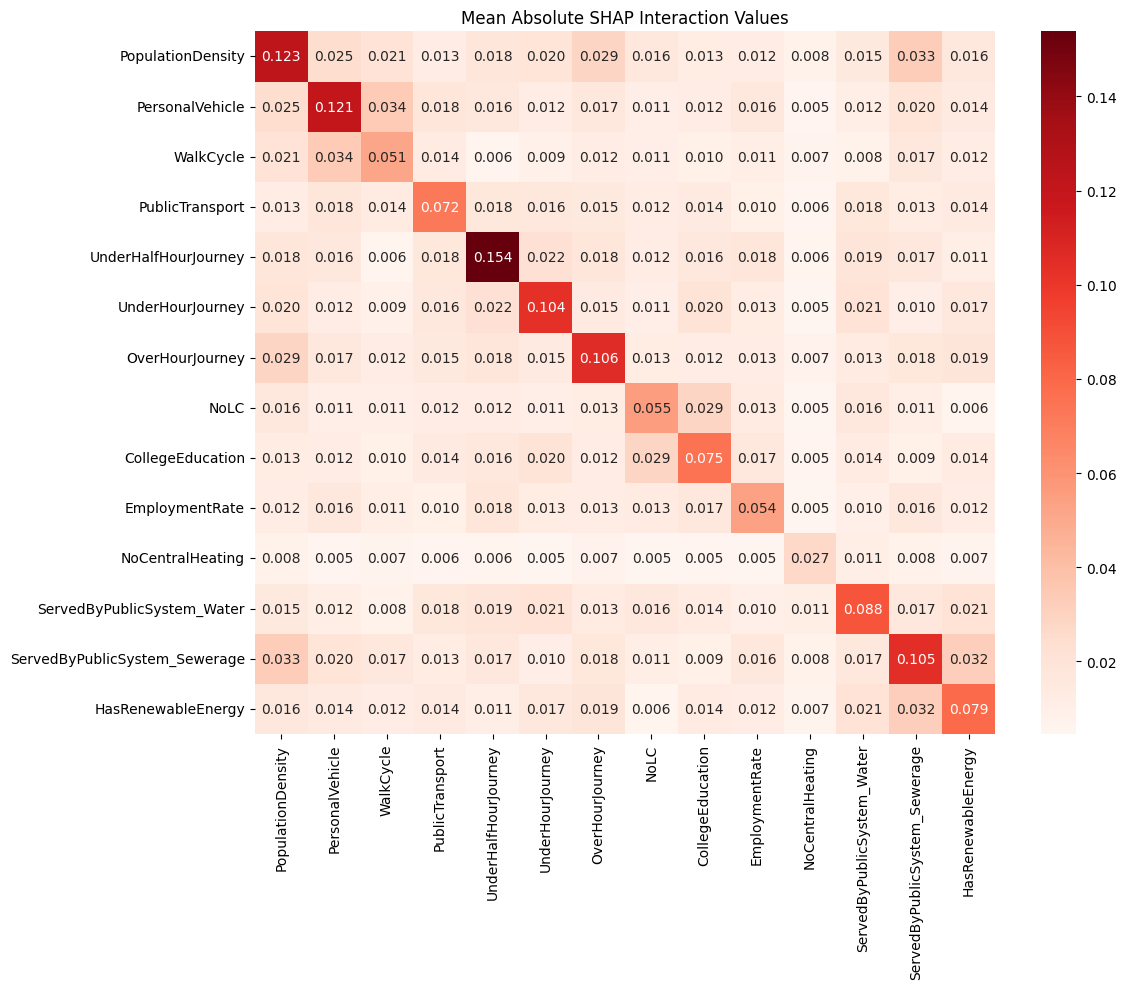

Top 5 interacting feature pairs (mean |SHAP|):
PersonalVehicle ↔ WalkCycle : 0.0340
PopulationDensity ↔ ServedByPublicSystem_Sewerage : 0.0328
ServedByPublicSystem_Sewerage ↔ HasRenewableEnergy : 0.0320
PopulationDensity ↔ OverHourJourney : 0.0287
NoLC ↔ CollegeEducation : 0.0287

Dependence plot for PersonalVehicle interacting with WalkCycle


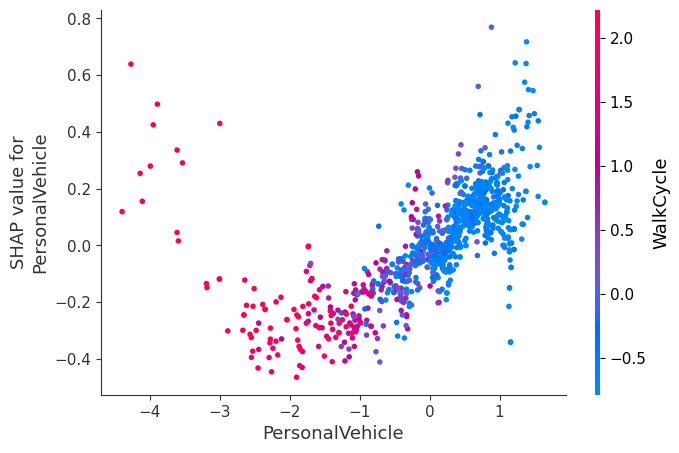


Dependence plot for PopulationDensity interacting with ServedByPublicSystem_Sewerage


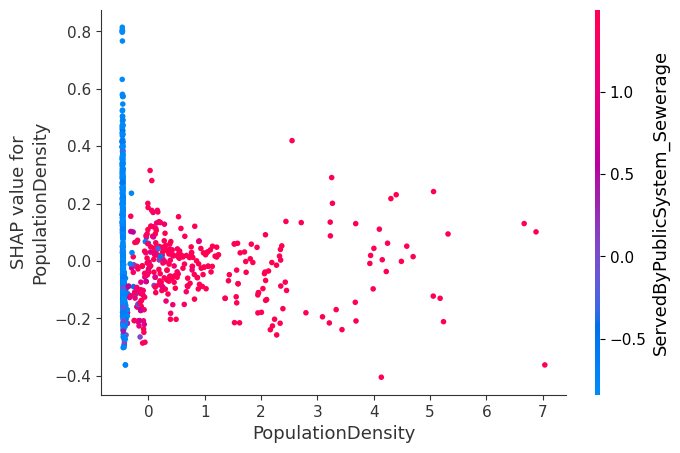


Dependence plot for ServedByPublicSystem_Sewerage interacting with HasRenewableEnergy


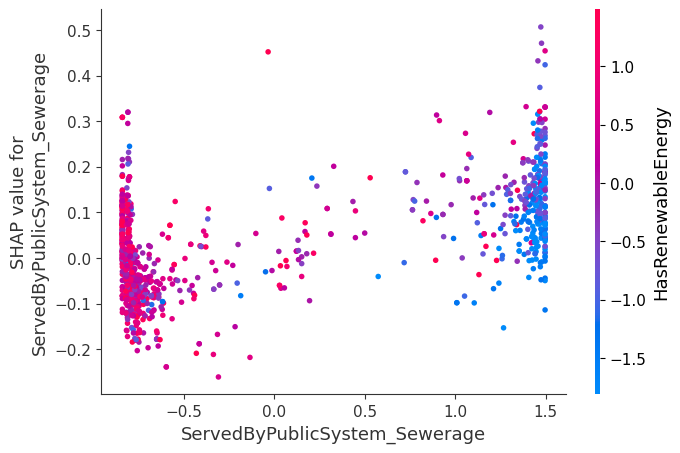


Dependence plot for PopulationDensity interacting with OverHourJourney


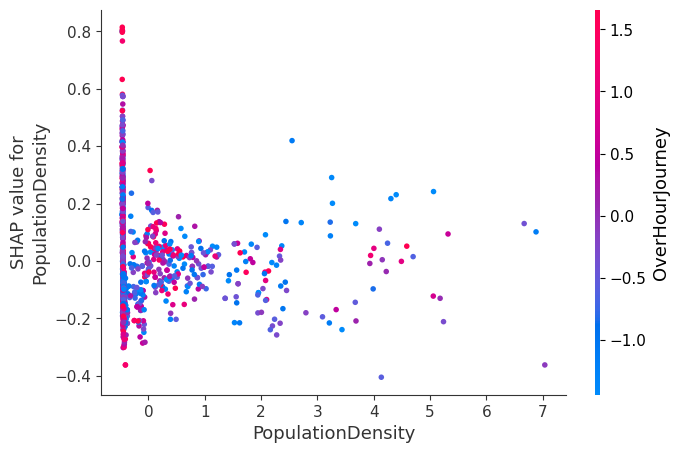


Dependence plot for NoLC interacting with CollegeEducation


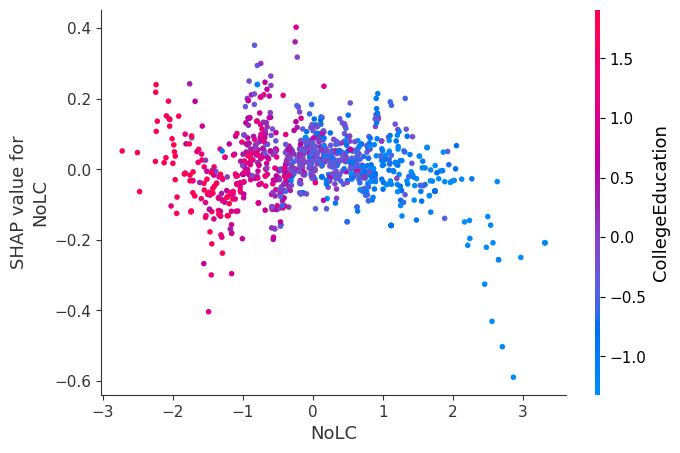

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

#Computed SHAP interaction values for features

#Selected random sample of 1000 rows for quicker completion time
X_test_sample = X_test_df.sample(1000, random_state=42)

# Created SHAP TreeExplainer
explainer = shap.TreeExplainer(xgb_best)

#Computed SHAP interaction values for the test set
shap_interact = explainer.shap_interaction_values(X_test_sample)

#Created matrix and heatmap graph of SHAP interaction values
interaction_matrix = np.abs(shap_interact).mean(axis=0)
interaction_df = pd.DataFrame(interaction_matrix,
                              index=selected_cols,
                              columns=selected_cols)

plt.figure(figsize=(12,10))
sns.heatmap(interaction_df, annot=True, fmt=".3f", cmap="Reds")
plt.title("Mean Absolute SHAP Interaction Values")
plt.tight_layout()
plt.show()

#Selected top 5 most interacting feature pairs
upper = np.triu(np.abs(interaction_matrix), k=1)
top_indices = np.dstack(np.unravel_index(np.argsort(upper.ravel())[-5:], upper.shape))[0]

#Outputted top 5 pairs with score
top_pairs = []
print("Top 5 interacting feature pairs (mean |SHAP|):")
for idx in reversed(top_indices):
    i, j = idx
    feat_i = selected_cols[i]
    feat_j = selected_cols[j]
    value = interaction_matrix[i, j]
    top_pairs.append((feat_i, feat_j, value))
    print(f"{feat_i} ↔ {feat_j} : {value:.4f}")

#Created dependence plots for top 5 dependencies
for feat_i, feat_j, value in top_pairs:
    print(f"\nDependence plot for {feat_i} interacting with {feat_j}")
    shap.dependence_plot(
        feat_i,
        explainer.shap_values(X_test_sample),
        X_test_sample,
        interaction_index=feat_j
    )


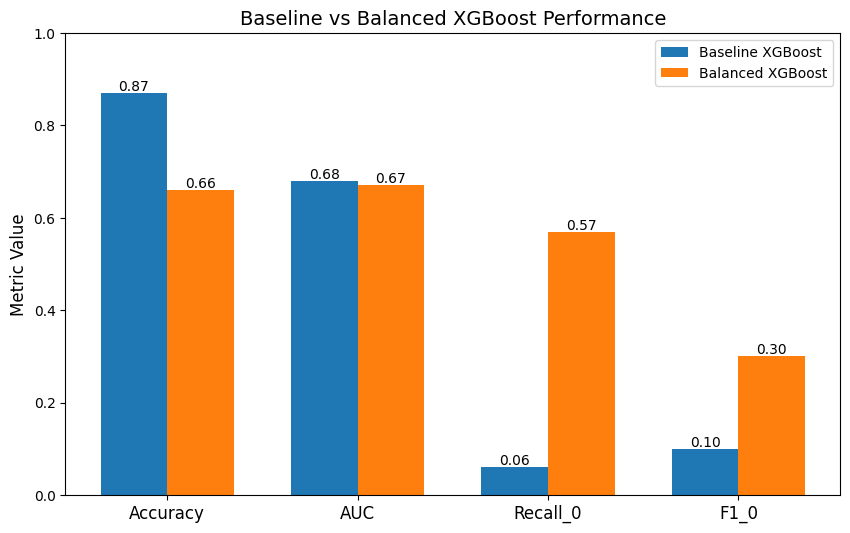

In [14]:
#Created bar chart comparing baseline gradient boosting model vs after class balancing applied

#Defined key metrics
metrics = ["Accuracy", "AUC", "Recall_0", "F1_0"]

#Baseline matric values
baseline_values = [
    0.87,
    0.68,
    0.06,
    0.1
]

#Metrics after class balancing applied
balanced_values = [
    0.66,
    0.67,
    0.57,
    0.3
]

#Created bar chart using matplotlib
x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(10,6))

plt.bar(x - width/2, baseline_values, width, label="Baseline XGBoost")
plt.bar(x + width/2, balanced_values, width, label="Balanced XGBoost")

plt.xticks(x, metrics, fontsize=12)

#Added axis labels and title
plt.ylabel("Metric Value", fontsize=12)
plt.title("Baseline vs Balanced XGBoost Performance", fontsize=14)
plt.legend()

# Add value labels above bars
for i, v in enumerate(baseline_values):
    plt.text(i - width/2, v + 0.005, f"{v:.2f}", ha='center')

for i, v in enumerate(balanced_values):
    plt.text(i + width/2, v + 0.005, f"{v:.2f}", ha='center')

#Outputted graph
plt.ylim(0, 1)
plt.show()
